In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
colors=px.colors.qualitative.Plotly
temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), width=1400))
from itertools import cycle
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression

#colors = cycle(px.colors.sequential.Viridis + px.colors.sequential.Viridis + px.colors.sequential.Plasma + px.colors.sequential.solar)


for dirname, _, filenames in os.walk('/kaggle/input/store-sales-time-series-forecasting'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
CUR_DIR= "/kaggle/input/store-sales-time-series-forecasting"

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
%%time

df_oil = pd.read_csv(os.path.join(CUR_DIR, 'oil.csv'), parse_dates=['date'])
df_sample_submission = pd.read_csv(os.path.join(CUR_DIR, 'sample_submission.csv'))
df_holidays_events = pd.read_csv(os.path.join(CUR_DIR, 'holidays_events.csv'), parse_dates=['date'])
df_stores = pd.read_csv(os.path.join(CUR_DIR, 'stores.csv'))
df_train = pd.read_csv(os.path.join(CUR_DIR, 'train.csv'), parse_dates=['date'])
df_test = pd.read_csv(os.path.join(CUR_DIR, 'test.csv'), parse_dates=['date'])
df_transactions = pd.read_csv(os.path.join(CUR_DIR, 'transactions.csv'), parse_dates=['date'])

CPU times: user 1.95 s, sys: 470 ms, total: 2.42 s
Wall time: 3.97 s


In [4]:
def summarize(df, file_name, n_rows_to_show=5):
    """Simply summarize the given DataFrame.
    
    Parameters:
        df: pd.DataFrame, raw DataFrame
        file_name: str, name of the file
        n_rows_to_show: int, number of rows to show 
    """
    print(f"=====Summary of {file_name}=====")
    print(f"\n\nThe data shape and types are:\n")
    display(df.info())
    print(f"\n\nThe column data statistics: \n{df.describe()}\n\n")
    print(f"The number of unique values per column: \n{df.nunique()}\n\n")
    
    
    nan_ratio = pd.isna(df).sum() / len(df) * 100
    nan_ratio.sort_values(ascending=False, inplace=True)
    nan_ratio = nan_ratio.to_frame(name='NaN Ratio').T
    print("NaN ratio:")
    display(nan_ratio)   
    
    display(df.head(n_rows_to_show))

In [5]:
df_holidays_events.drop(columns=[ 'description', 'transferred'],inplace = True)
df_holidays_events["Hcount"] = True
new_train = pd.DataFrame()
new_train= pd.merge(df_train,df_oil,how="left",on=["date"])
new_train= pd.merge(new_train,df_holidays_events,how="left",on=["date"])
new_train= pd.merge(new_train,df_stores,how="left",on=["store_nbr"])

In [6]:
new_train.rename(columns = {'type_x':'holiday_type', 'type_y':'store_type'}, inplace = True)

In [7]:
new_train["month"] = new_train.date.dt.month
new_train["day_of_week"] = new_train.date.dt.isocalendar().day
new_train["week"] = new_train.date.dt.isocalendar().week
new_train["year"] = new_train.date.dt.isocalendar().year
new_train["day_of_year"] = new_train.date.dt.dayofyear

In [9]:
summarize(new_train, 'new_train')

=====Summary of new_train=====


The data shape and types are:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 20 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   dcoilwtico    float64       
 7   holiday_type  object        
 8   locale        object        
 9   locale_name   object        
 10  Hcount        object        
 11  city          object        
 12  state         object        
 13  store_type    object        
 14  cluster       int64         
 15  month         int64         
 16  day_of_week   UInt32        
 17  week          UInt32        
 18  year          UInt32        
 19  day_of_year   int64         
dtypes: UInt32(3), datetime64[ns](1), float64(2), int64(6), object(8)
memor

None



The column data statistics: 
                 id     store_nbr         sales   onpromotion    dcoilwtico  \
count  3.054348e+06  3.054348e+06  3.054348e+06  3.054348e+06  2.099196e+06   
mean   1.504277e+06  2.750000e+01  3.590209e+02  2.617480e+00  6.801587e+01   
std    8.662610e+05  1.558579e+01  1.107286e+03  1.225494e+01  2.569134e+01   
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  2.619000e+01   
25%    7.546768e+05  1.400000e+01  0.000000e+00  0.000000e+00  4.641000e+01   
50%    1.507572e+06  2.750000e+01  1.100000e+01  0.000000e+00  5.343000e+01   
75%    2.255120e+06  4.100000e+01  1.960110e+02  0.000000e+00  9.581000e+01   
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02  1.106200e+02   

            cluster         month   day_of_week          week          year  \
count  3.054348e+06  3.054348e+06  3.054348e+06  3.054348e+06  3.054348e+06   
mean   8.481481e+00  6.222870e+00  4.008168e+00  2.530863e+01  2.014843e+03   
std    4.649735e+00 

,Hcount,holiday_type,locale,locale_name,dcoilwtico,state,year,week,day_of_week,month,cluster,store_type,id,city,date,onpromotion,sales,family,store_nbr,day_of_year
NaN Ratio,83.547258,83.547258,83.547258,83.547258,31.271879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,Hcount,city,state,store_type,cluster,month,day_of_week,week,year,day_of_year
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,True,Quito,Pichincha,D,13,1,2,1,2013,1
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,True,Quito,Pichincha,D,13,1,2,1,2013,1
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,True,Quito,Pichincha,D,13,1,2,1,2013,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,National,Ecuador,True,Quito,Pichincha,D,13,1,2,1,2013,1
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,National,Ecuador,True,Quito,Pichincha,D,13,1,2,1,2013,1


In [10]:
columns=['date','sales','store_type', 'cluster', 'state' , 'city', 'store_nbr']
df= new_train[columns].copy()

In [10]:
df.head(10000)

,date,sales,store_type,cluster,state,city,store_nbr
0,2013-01-01,0.00,D,13,Pichincha,Quito,1
1,2013-01-01,0.00,D,13,Pichincha,Quito,1
2,2013-01-01,0.00,D,13,Pichincha,Quito,1
3,2013-01-01,0.00,D,13,Pichincha,Quito,1
4,2013-01-01,0.00,D,13,Pichincha,Quito,1
...,...,...,...,...,...,...,...
9995,2013-01-06,47.00,B,6,Azuay,Cuenca,39
9996,2013-01-06,0.00,B,6,Azuay,Cuenca,39
9997,2013-01-06,0.00,B,6,Azuay,Cuenca,39
9998,2013-01-06,19.54,B,6,Azuay,Cuenca,39


In [11]:
df['salesSum']= df.groupby('date')['sales'].transform('mean')
#df['storeTypeSum']= df.groupby(['date','store_type'])['sales'].transform('sum')
#df['clusterSum']= df.groupby(['date','cluster'])['sales'].transform('sum')
#df['stateSum']= df.groupby(['date','state'])['sales'].transform('sum')
#df['citySum']= df.groupby(['date','city'])['sales'].transform('sum')
#df['storeSum']= df.groupby(['date','store_nbr'])['sales'].transform('sum')
#df.drop(columns=['sales','store_type', 'cluster', 'state' , 'city', 'store_nbr'])

In [12]:
df1 = df.drop_duplicates(subset = ["date"]).drop(columns = ['sales','store_type', 'cluster', 'state' , 'city', 'store_nbr'])

In [13]:
df1 = df1.set_index('date').to_period("D")

In [30]:
df1.head()

,salesSum
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244


In [42]:
dp = DeterministicProcess(
    index=df1.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=4,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed,trend**4
date,,,,,
2013-01-01,1.0,1.0,1.0,1.0,1.0
2013-01-02,1.0,2.0,4.0,8.0,16.0
2013-01-03,1.0,3.0,9.0,27.0,81.0
2013-01-04,1.0,4.0,16.0,64.0,256.0
2013-01-05,1.0,5.0,25.0,125.0,625.0


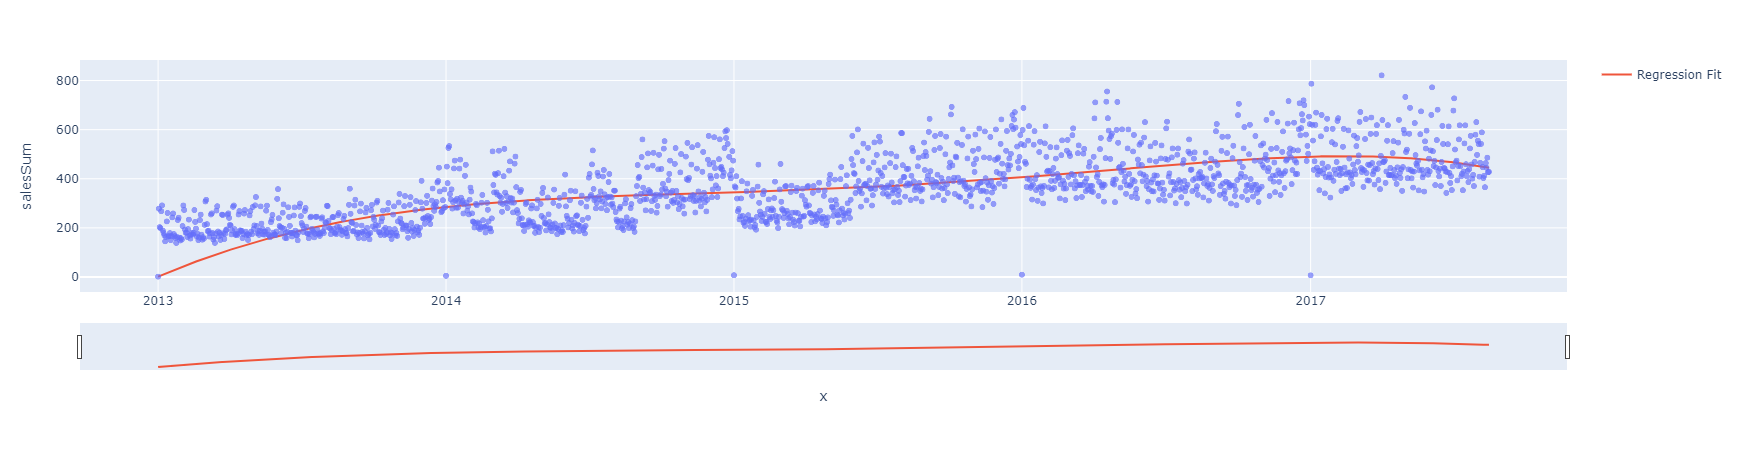

In [40]:
y = df1["salesSum"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)


#x_range = np.linspace(X.min(), X.max(), 100)
#y_range = model.predict(x_range.reshape(-1, 1))

fig = px.scatter(df1, x=df1.index.to_timestamp(), y='salesSum', opacity=0.65)
fig.add_traces(go.Scatter(x=X.index.to_timestamp(), y=y_pred, name='Regression Fit'))
fig.update_xaxes(rangeslider_visible= True)
fig.show()

# **Seasonal indicators**

Seasonal indicators are binary features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding.

By one-hot encoding days of the week, we get weekly seasonal indicators. Creating weekly indicators for the Trigonometry series will then give us six new "dummy" features. *(Linear regression works best if you drop one of the indicators; we chose Monday in the frame below.)*

Adding seasonal indicators to the training data helps models distinguish means within a seasonal period:



I am trying to show the seasonal plot on a wekly basis and on a monthly basis for various years and months.

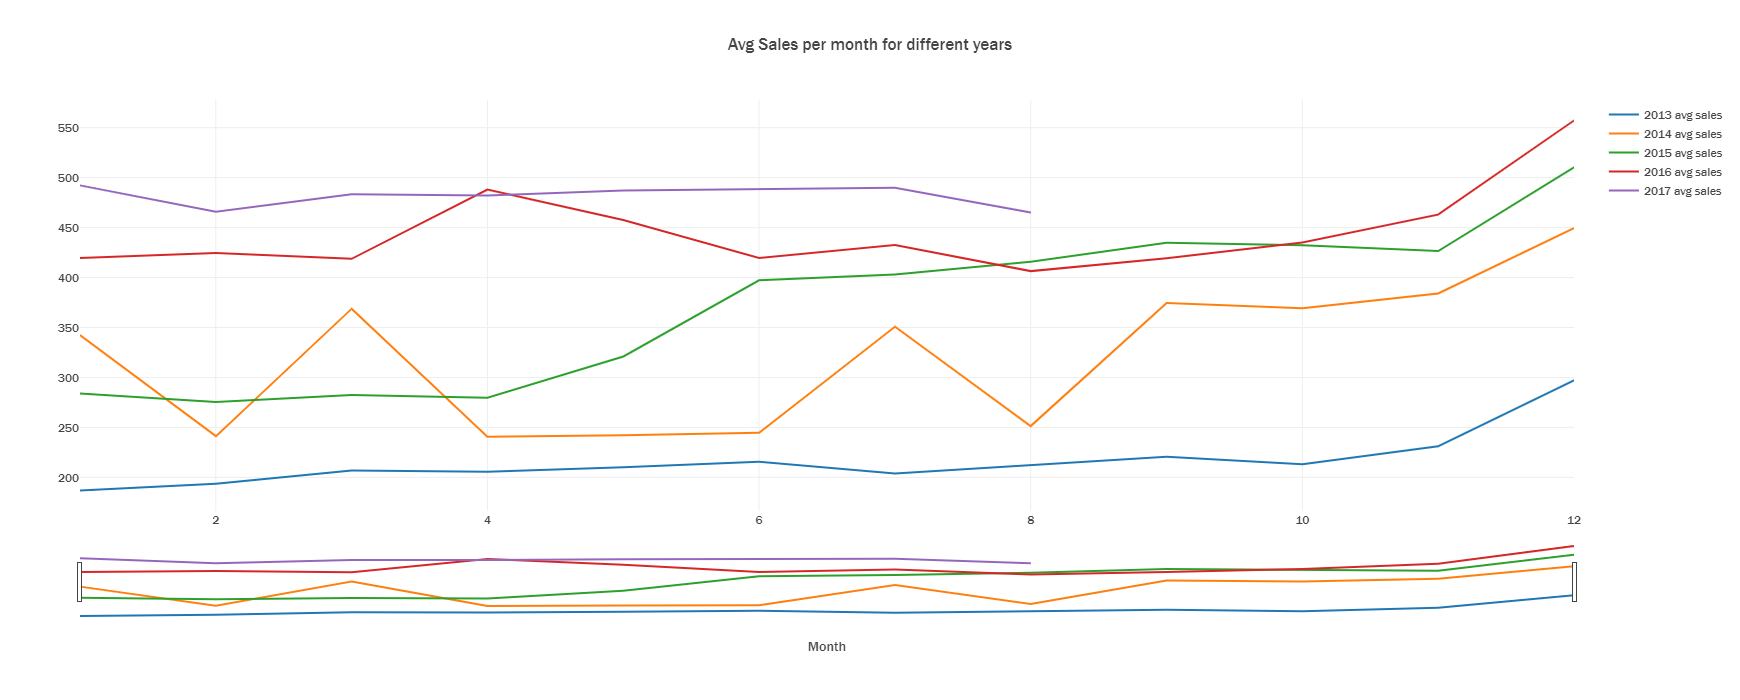

In [43]:
month = new_train.sort_values(by='month').month.unique()
year = list(new_train.year.unique())
avg_sales = new_train.sort_values(by='month').groupby('month')['sales'].mean()


buttons=[]



fig = go.Figure()

for i in range (len(year)):
    avg_sales=new_train[new_train.year == year[i]].sort_values(by='month').groupby('month')['sales'].mean()

        
    fig.add_trace(go.Scatter(x=month, y= avg_sales, name = str(year[i]) + " avg sales", mode='lines'  ))





fig.update_xaxes(rangeslider_visible= True)

fig.update_layout(template=temp,title='Avg Sales per month for different years', 
                  #autosize=False, 
                  width=1400, 
                  height=700, 
                  xaxis_title="Month", 
                  yaxis_title="",
                  hovermode='x unified',
                  showlegend=True,

                  
                 )
fig.show()

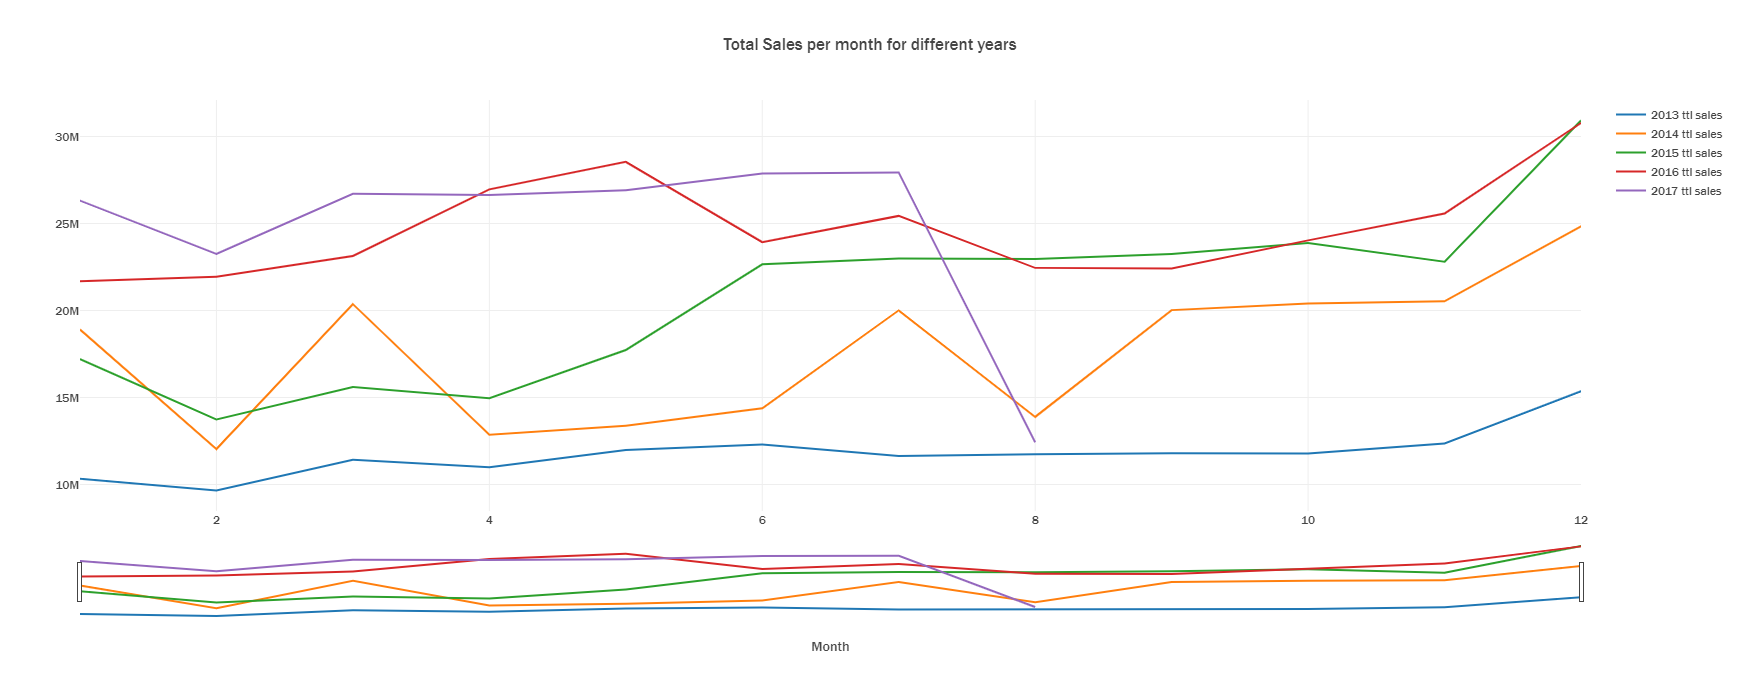

In [47]:
month = new_train.sort_values(by='month').month.unique()
year = list(new_train.year.unique())
ttl_sales = new_train.sort_values(by='month').groupby('month')['sales'].median()


buttons=[]



fig = go.Figure()

for i in range (len(year)):
    ttl_sales=new_train[new_train.year == year[i]].sort_values(by='month').groupby('month')['sales'].sum()

        
    fig.add_trace(go.Scatter(x=month, y= ttl_sales, name = str(year[i]) + " ttl sales", mode='lines'  ))





fig.update_xaxes(rangeslider_visible= True)

fig.update_layout(template=temp,title='Total Sales per month for different years', 
                  #autosize=False, 
                  width=1400, 
                  height=700, 
                  xaxis_title="Month", 
                  yaxis_title="",
                  hovermode='x unified',
                  showlegend=True,

                  
                 )
fig.show()

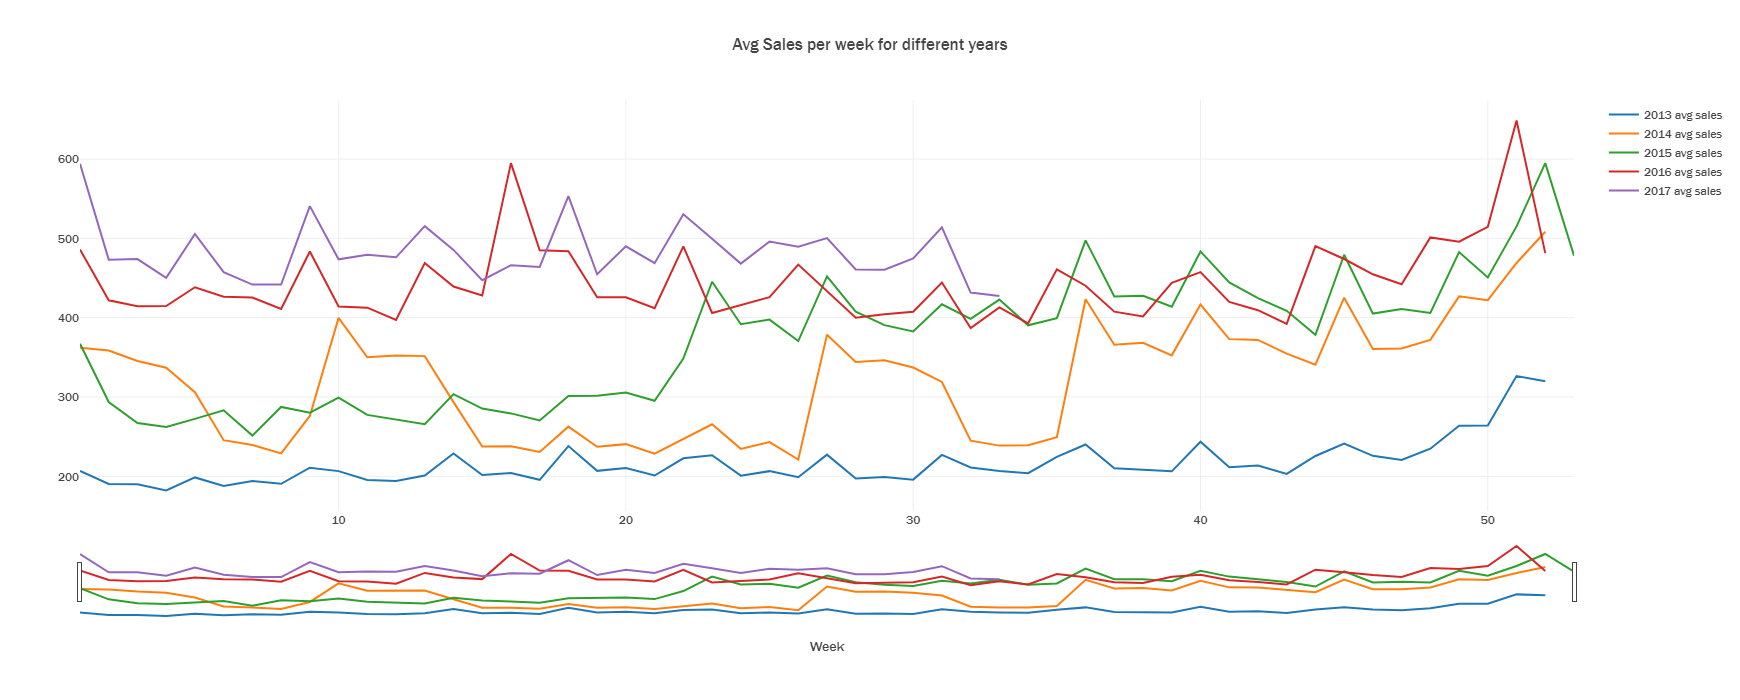

In [48]:
week = new_train.sort_values(by='week').week.unique()
year = list(new_train.year.unique())
avg_sales = new_train.sort_values(by='week').groupby('week')['sales'].mean()



fig = go.Figure()

for i in range (len(year)):
    avg_sales=new_train[new_train.year == year[i]].sort_values(by='week').groupby('week')['sales'].mean()

        
    fig.add_trace(go.Scatter(x=week, y= avg_sales, name = str(year[i]) + " avg sales", mode='lines'  ))





fig.update_xaxes(rangeslider_visible= True)

fig.update_layout(template=temp,title='Avg Sales per week for different years', 
                  #autosize=False, 
                  width=1400, 
                  height=700, 
                  xaxis_title="Week", 
                  yaxis_title="",
                  hovermode='x unified',
                  showlegend=True,

                  
                 )
fig.show()

In [54]:
new_train.sort_values(by=['year','day_of_year']).day_of_year.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

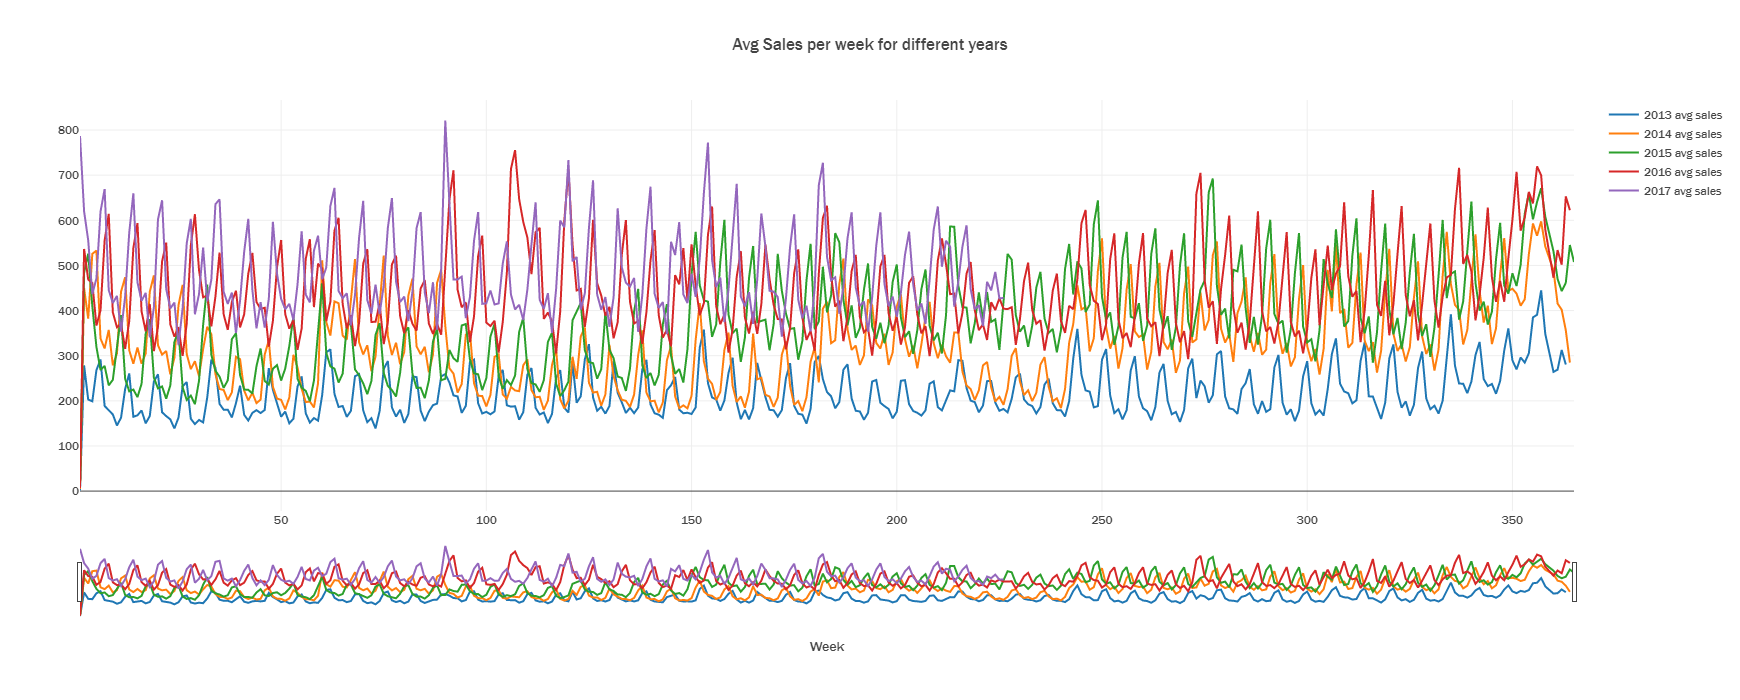

In [55]:
day = new_train.sort_values(by=['year','day_of_year']).day_of_year.unique()
year = list(new_train.year.unique())
#avg_sales = new_train.sort_values(by=['year','day_of_year']).groupby('day_of_year')['sales'].mean()



fig = go.Figure()

for i in range (len(year)):
    avg_sales=new_train[new_train.year == year[i]].sort_values(by='day_of_year').groupby('day_of_year')['sales'].mean()

        
    fig.add_trace(go.Scatter(x=day, y= avg_sales, name = str(year[i]) + " avg sales", mode='lines'  ))





fig.update_xaxes(rangeslider_visible= True)

fig.update_layout(template=temp,title='Avg Sales per week for different years', 
                  #autosize=False, 
                  width=1400, 
                  height=700, 
                  xaxis_title="Week", 
                  yaxis_title="",
                  hovermode='x unified',
                  showlegend=True,

                  
                 )
fig.show()

In [ ]:
day = new_train.sort_values(by=['year','week','day_of_week']).day_of_week.unique()
year = list(new_train.year.unique())
week = list(new_train.week.unique())
#avg_sales = new_train.sort_values(by=['year','week','day_of_week']).groupby('day_of_week')['sales'].mean()



fig = make_subplots(rows=len(year), cols=1,
                    #shared_xaxes=True,
                    #vertical_spacing=0.02
                   )

for i in range (len(year)):
    for d in range (int(len(week)/2)):
        avg_sales=new_train[(new_train.year == year[i]) & (new_train.week == week[d])].sort_values(by=['year','week','day_of_week']).groupby('day_of_week')['sales'].mean()
        fig.add_trace(go.Scatter(x=day, y= avg_sales, name = str(year[i]) + ' week' +str(week[d]) + " avg sales", mode='lines'  ), row=i +1, col=1)

        
    





#fig.update_xaxes(rangeslider_visible= True)

fig.update_layout(#template=temp,
                  title='Avg Sales per day for different years', 
                  #autosize=False, 
                  width=1400, 
                  height=2000, 
                  xaxis_title="Week", 
                  yaxis_title="",
                  hovermode='x unified',
                  showlegend=True,

                  
                 )
fig.show()

Trying to make a periodogram

In [19]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version



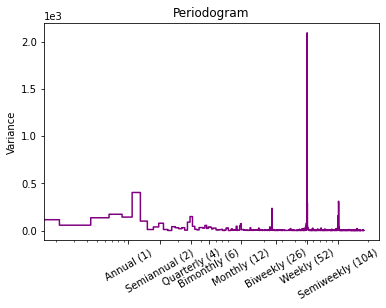

In [20]:
plot_periodogram(df1.salesSum);

Reference from notes.

The periodogram agrees with the seasonal plots above: a strong weekly season and a weaker annual season. The weekly season we'll model with indicators and the annual season with Fourier features. From right to left, the periodogram falls off between Bimonthly (6) and Monthly (12), so let's use 10 Fourier pairs.

We'll create our seasonal features using DeterministicProcess, the same utility we used in Lesson 2 to create trend features. To use two seasonal periods (weekly and annual), we'll need to instantiate one of them as an "additional term":

1. periodogram?
2. how many fourier pairs to use? ref exercise.

In [60]:
fourier = CalendarFourier(freq="A", order=2)  # 2 sin/cos pairs for "A"nnual seasonality

dp2 = DeterministicProcess(
    index=df1.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp2.in_sample()
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)"
date,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,0.034422,0.999407
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,0.068802,0.997630
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,0.103102,0.994671
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,0.137279,0.990532


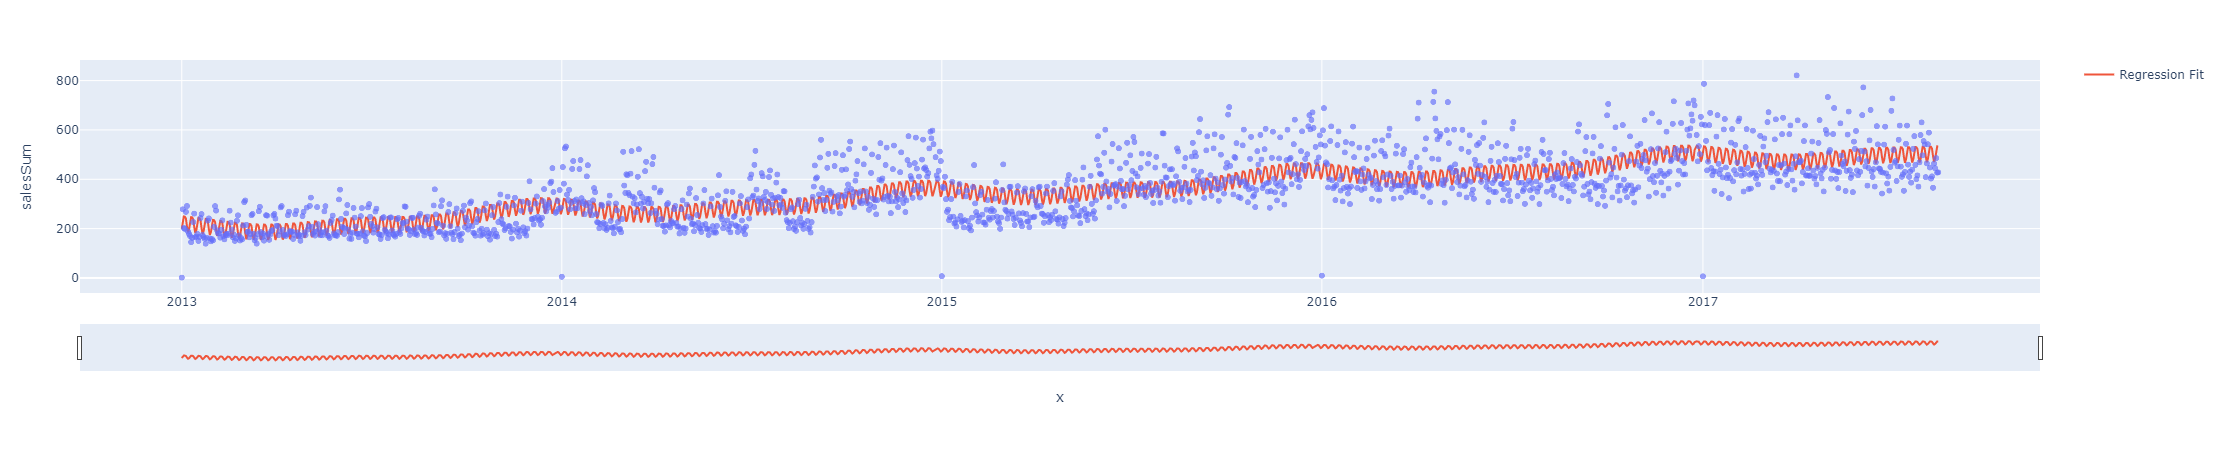

In [68]:
y = df1["salesSum"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)


#x_range = np.linspace(X.min(), X.max(), 100)
#y_range = model.predict(x_range.reshape(-1, 1))

fig = px.scatter(df1, x=df1.index.to_timestamp(), y='salesSum', opacity=0.65)
fig.add_traces(go.Scatter(x=X.index.to_timestamp(), y=y_pred, name='Regression Fit'))
fig.update_xaxes(rangeslider_visible= True)
fig.show()

# **Visualizing coefficients**

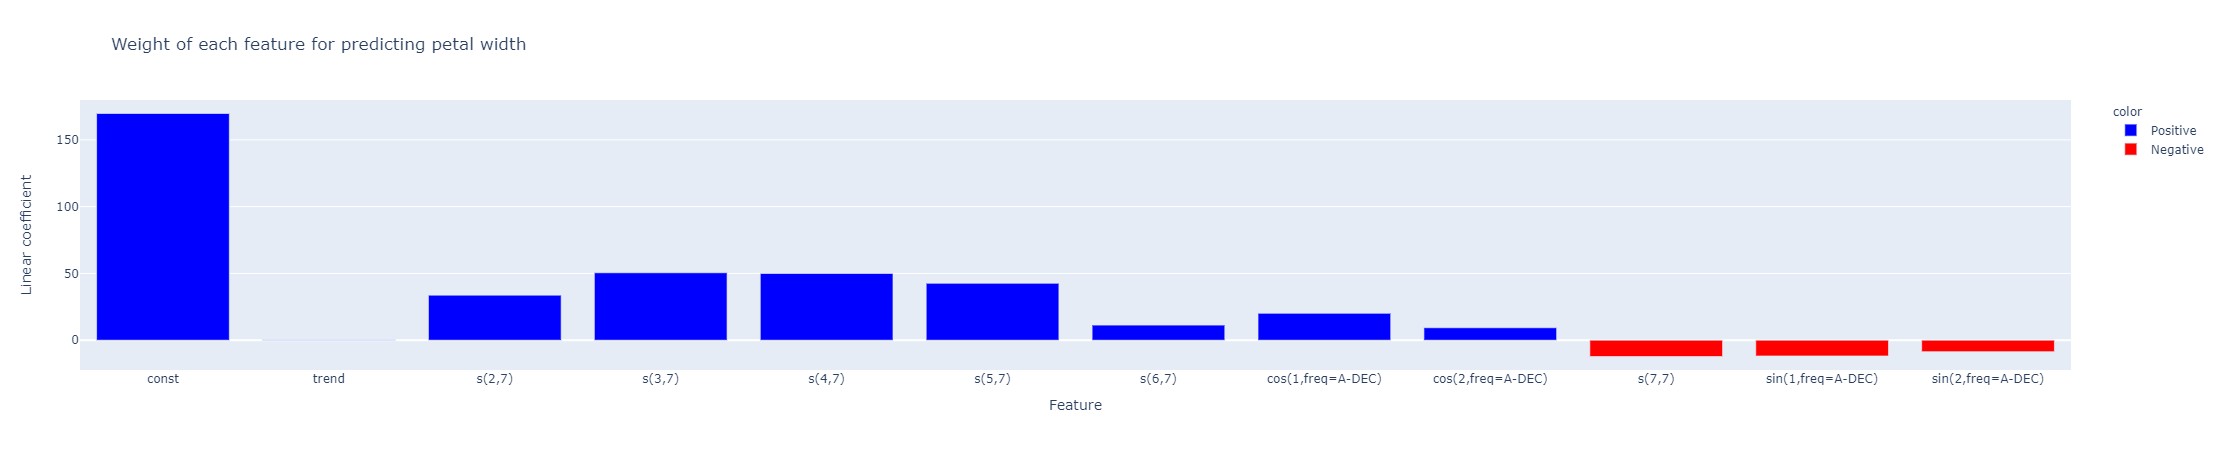

In [71]:
colors = ['Positive' if c > 0 else 'Negative' for c in model.coef_]

fig = px.bar(
    x=X.columns, y=model.coef_, color=colors,
    color_discrete_sequence=['blue', 'red'],
    labels=dict(x='Feature', y='Linear coefficient'),
    title='Weight of each feature for predicting petal width'
)
fig.show()

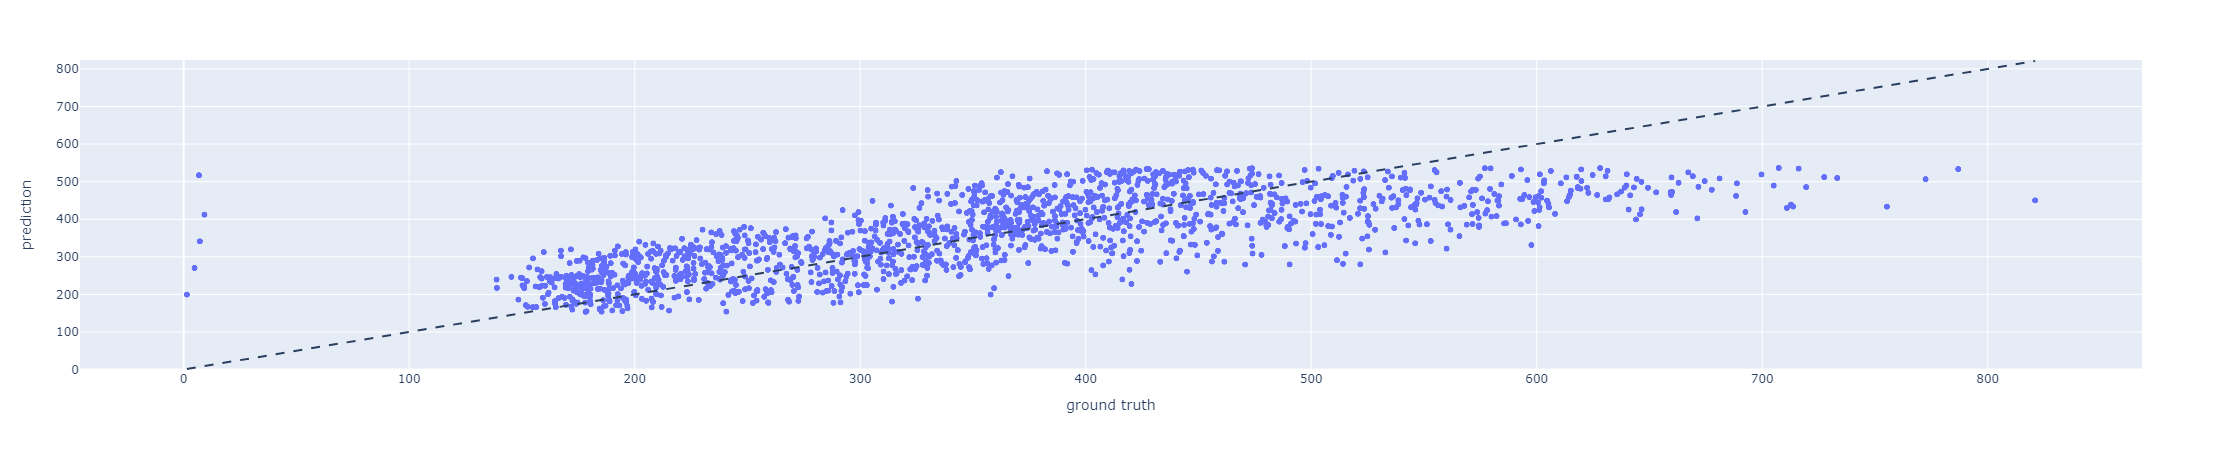

In [72]:
fig = px.scatter(x=y, y=y_pred, labels={'x': 'ground truth', 'y': 'prediction'}, title='Actual vs predicted plot')
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=y.min(), y0=y.min(),
    x1=y.max(), y1=y.max()
)
fig.show()